# OLS Simulation for an the "Approximate Maximum Influence Perturbation"

* Relevant paper: https://arxiv.org/pdf/2011.14999.pdf <br>
* Recreation of simulated OLS case (i.e., Figure 1)<br>

### Summary of approach for univariate OLS (ordinary least squares) simulation: 
1. Generate a set $N$ of data points:
$$
\begin{align}
    d_n = \left(x_n, y_n \right) \
        \begin{cases}
            & x_n \in \mathcal{N}\left(0, \sigma_x^2\right)\\
            & y_n = \theta x_n + \epsilon_n \
                 \begin{cases}
                      & \epsilon_n \in \mathcal{N}\left(0, \sigma_e^2\right)\\
                      & \theta \in \mathbb{R} \\
                 \end{cases}  
        \end{cases}  
\end{align}
$$

1. Run a linear regression on the data to find an approximation for the quantity of intrest: $\hat{\theta}_N$ with residuals, $r_n$.
1. Check assumptions of linear regression:
    1. Independence - residuals are independant
    1. Normality - residuals are normally distributed
    1. Homoscedasticity - residuals have constant variance across values of x
    1. Linearity - linear relationship between x and y
1. Compute influence function for the regressor, $x_n$.
1. Compute signals:
    1. Compute the influence scores for each datapoint, $d_n$. Meaning, evaluate the the emeprical influence function at $(x_n, y_n)$ to get $\psi_n$.
    1. Iteratively remove the smallest influence score, $\psi_n$, until the signal, $\Delta = |\hat{\theta}|$ (for sign changing case), is reached (meaning there is a change the sign of the estimator). The change after the signal has been reached is then the <b>Maximum Influence Pertubration</b>: 
    $$
    \begin{align}
        \Psi_{\alpha} \
            \begin{cases}
                & \alpha = |\psi_{removed}|\\
                & \Psi_{\alpha} > \Delta = \hat{\theta}_N
            \end{cases}  
    \end{align}
    $$
    If the signal is never reached then $\Psi_{\alpha} = $ NA.
1. Drop points from the <b>Most Influential Set</b>, $S_{\alpha}$. And the <b>Perturbation Inducing Proportion</b> reported is:

    $$
    \begin{align}
        \alpha_{\Delta} = \frac{|S_{\alpha}|}{|N|}
    \end{align}
    $$

1. Re-run the linear regression without the Most Influential Set, $N \notin S_{\alpha}$, to confirm that the quantity of intrest has changed the sign, significance, or both from the original quantitiy of intrest:

$$
\begin{align}
    \hat{\theta}_N \quad vs. \quad \hat{\theta}_N \notin S_{\alpha}
\end{align}
$$

## 0. Setup

In [38]:
library(devtools)
library(zaminfluence)
library(tidyr)
library(dplyr)
library(ggplot2)
library(grid)
library(gridExtra)
library(pracma)
library(scales)
library(ggfortify)
library(repr)

In [39]:
set.seed(42)
options(repr.plot.width=8, repr.plot.height=8) #Set default plot size

## 1. Generate Datapoints 

In [40]:
#Returns a data frame with simulated OLS data in the form of y = theta*x + e
OLSDataGenerator <- function(x_sd, e_sd, x_mu=0, e_mu=0, theta=.5, n=5000){
  df <- data.frame("x"=rnorm(n, mean=x_mu, sd=x_sd))
  df$e <- rnorm(n, mean=e_mu, sd=e_sd)
  df$y <- theta*df$x + df$e
  return(df)
}

       x                  e                   y            
 Min.   :-3.37174   Min.   :-80.86553   Min.   :-81.09184  
 1st Qu.:-0.68542   1st Qu.:-14.12064   1st Qu.:-14.04234  
 Median :-0.01143   Median : -0.03249   Median : -0.01929  
 Mean   :-0.01439   Mean   : -0.16452   Mean   : -0.17171  
 3rd Qu.: 0.65993   3rd Qu.: 13.31171   3rd Qu.: 13.39363  
 Max.   : 3.58466   Max.   : 86.56183   Max.   : 86.92057  

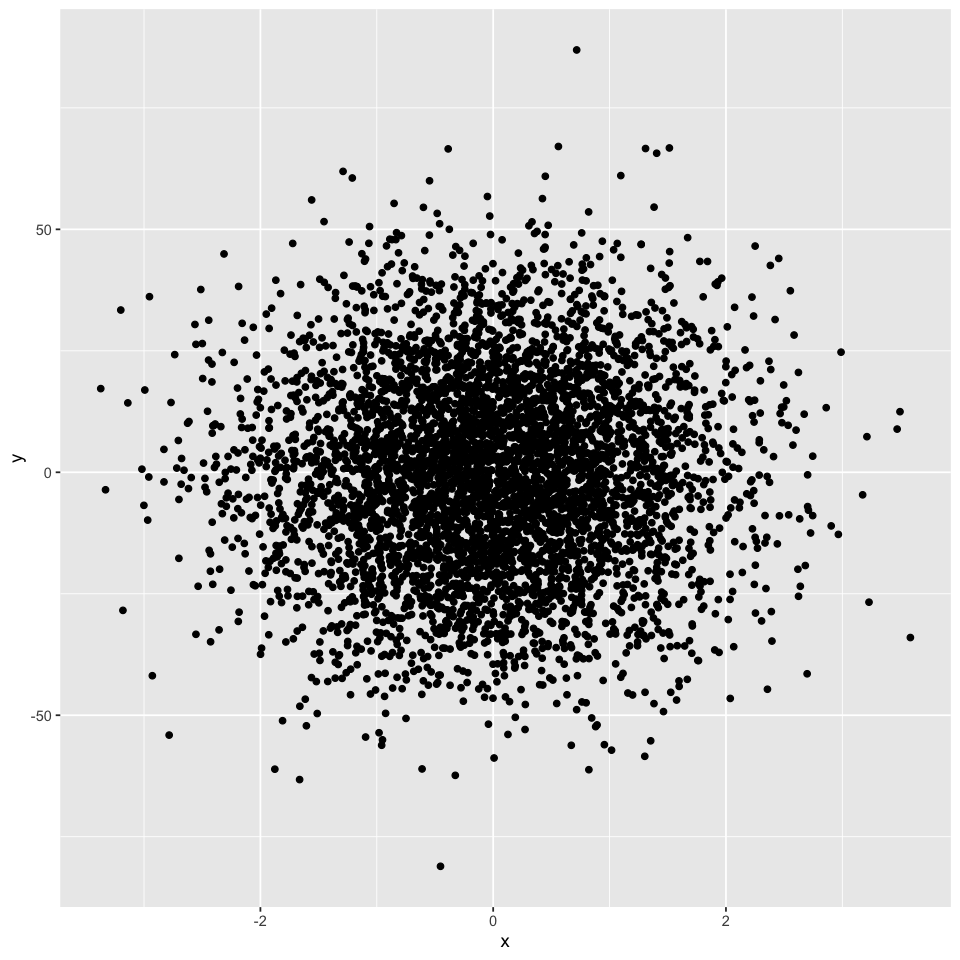

In [41]:
x_sd_ <- 1
e_sd_ <- 20
test_data <- OLSDataGenerator(x_sd_, e_sd_)
summary(test_data)
plot <- ggplot(test_data) + geom_point(aes(x=x, y=y))
plot

## 2. Run a Linear Regression

In [42]:
#Returns a linear regression
ModelMaker <- function(df){
  linear_model <- lm(df$y~df$x, x=TRUE, y=TRUE) #fit a linear model
  return(linear_model)
}


Call:
lm(formula = df$y ~ df$x, x = TRUE, y = TRUE)

Residuals:
   Min     1Q Median     3Q    Max 
-80.72 -13.96   0.12  13.48  86.76 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)
(Intercept)  -0.1652     0.2850  -0.580    0.562
df$x          0.4511     0.2836   1.591    0.112

Residual standard error: 20.15 on 4998 degrees of freedom
Multiple R-squared:  0.000506,	Adjusted R-squared:  0.0003061 
F-statistic:  2.53 on 1 and 4998 DF,  p-value: 0.1117


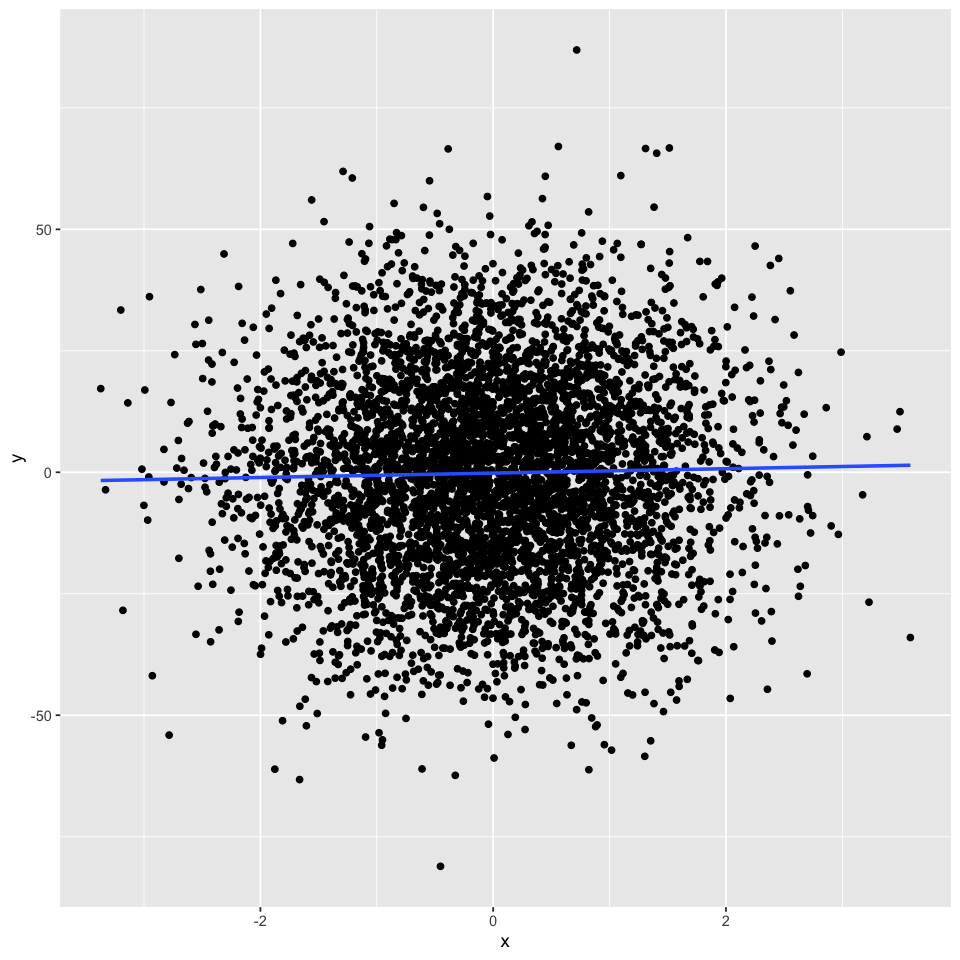

In [43]:
test_model <- ModelMaker(test_data)
summary(test_model)
plot +
     geom_smooth(aes(x=x, y=y),
                 formula = "y ~ x",
                 method='lm', 
                 se = FALSE)

## 3. Check Assumptions of Linear Regression

1. Independence - residuals are independant (true by construction)
1. Normality - residuals are normally distributed (true by construction)
1. Homoscedasticity - residuals have constant variance across values of x
1. Linearity - linear relationship between x and y

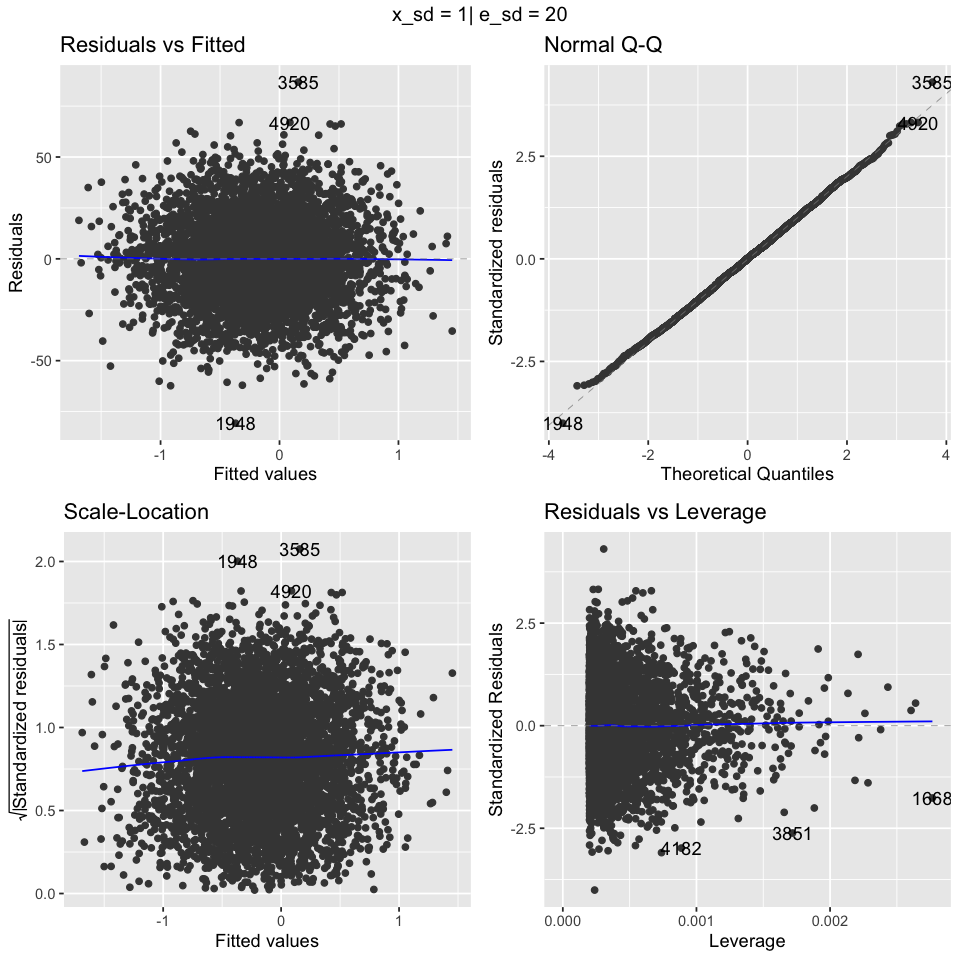

In [44]:
CheckOLSAssumptions <- function(model, x_sd, e_sd, n=5000){
    df <- OLSDataGenerator(x_sd, e_sd, n=n)
    plot <- autoplot(model, title="title")
    plot <- grid.arrange(grobs = plot@plots, top = sprintf("x_sd = %d| e_sd = %d", x_sd, e_sd))
    return(plot)
}

plot <- CheckOLSAssumptions(test_model, x_sd_, e_sd_) #assumptions hold

## 4. Compute Influence Function for Regressor

In [45]:
#Return the influence function for the regressor
ComputeInfluenceFunction <- function(model){
    model_grads <- ComputeModelInfluence(model) %>% 
                   AppendTargetRegressorInfluence("df$x")
    return(model_grads)
}

In [46]:
test_model_grads <- ComputeInfluenceFunction(test_model)

## 5. Compute Signals

In [47]:
#Return the signals for changes to sign, significance, and both.
ComputeSignals <- function(model_grads){
    signals <- GetInferenceSignals(model_grads)
    return(signals)
}

#Prints out a summary of the signals for a regressor
QOISummary <- function(roi){
  cat(" Sign: ", roi$sign$apip$success,
      "| Proportion: ", roi$sign$apip$prop,
      "| # of points ", roi$sign$apip$n, "\n",
      
      "Sig : ", roi$sig$apip$success,
      "| Proportion: ", roi$sig$apip$prop,
      "| # of points ", roi$sig$apip$n, "\n",
      
      "Both: ", roi$both$apip$success,
      "| Proportion: ", roi$both$apip$prop,
      "| # of points ", roi$both$apip$n, "\n")
}

In [48]:
test_signals <- ComputeSignals(test_model_grads)
test_roi <- test_signals$"df$x" #signal for the regressor of interest
QOISummary(test_roi)

 Sign:  TRUE | Proportion:  0.0052 | # of points  26 
 Sig :  TRUE | Proportion:  0.001 | # of points  5 
 Both:  TRUE | Proportion:  0.014 | # of points  70 


Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 7 rows containing missing values (`geom_bar()`).”


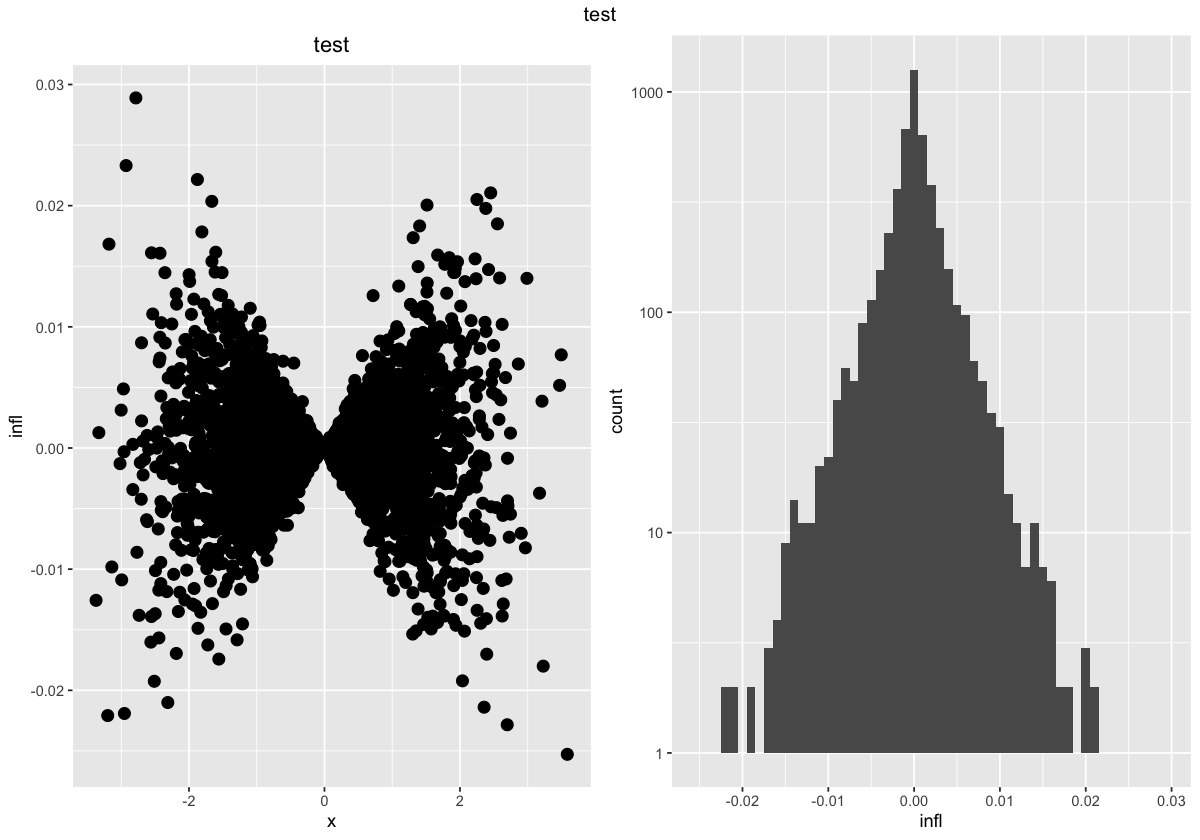

In [49]:
test_data$infl <- test_roi$sign$qoi$infl #Influence scores fore each datapoint

plot2 <- ggplot(test_data) +
      theme(plot.title = element_text(hjust = 0.5)) +
      ggtitle("test") +
      geom_point(aes(x=x, y=infl), size=3)

plot3 <- ggplot(test_data, aes(x=infl)) + 
         geom_histogram(binwidth=.001) + 
         scale_y_continuous(trans='log10')

options(repr.plot.width=10, repr.plot.height=7) #Set default plot size
grid.arrange(plot2, plot3, nrow = 1, ncol = 2, top = "test")

## 6. Drop Most Influential Set

In [50]:
#Returns a data frame with new columns indicating what data can be dropped to change each quantity of interest
DataDropper <- function(df, roi){
  df$dropsign <- FALSE
  df$dropsign[roi$sign$apip$inds] <- TRUE

  df$dropsig <- FALSE
  df$dropsig[roi$sig$apip$inds] <- TRUE
  
  df$dropboth <- FALSE
  df$dropboth[roi$both$apip$inds] <- TRUE
  
  return(df)
}

In [51]:
test_data <- DataDropper(test_data, test_roi)

#Confirm dropping by checking that Perturbation Inducing Proportion is equal to the size of the Most Influential Set
cat("Sign:", sum(test_data$dropsign)/5000 == test_roi$sign$apip$prop,
    "| Sig:", sum(test_data$dropsig)/5000 == test_roi$sig$apip$prop,
    "| Both:", sum(test_data$dropboth)/5000 == test_roi$both$apip$prop)

Sign: TRUE | Sig: TRUE | Both: TRUE

## 7. Rerun Linear Regression without Most Influential Set

In [52]:
#Return a linear model only fit on the datapoints not in the Most Influential Set
ModelMakerDropSign <- function(df){
    linear_model <- lm(df$y~df$x, x=TRUE, y=TRUE, subset=!df$dropsign) #fit a linear model
    return(linear_model)
}

ModelMakerOnlyDropSign <- function(df){
    linear_model <- lm(df$y~df$x, x=TRUE, y=TRUE, subset=!df$dropsign) #fit a linear model
    return(linear_model)
}

#Returns bool if two numbers are of different signs (pos/neg)
CheckOppositeSigns <- function(a, b){
    if ((a<0 & b>0) | (b<0 & a>0)){
        return(TRUE)
    }
    return(FALSE)
}

SummerizeReRun <- function(og, new, alpha){
    cat("It switched signs: ", 
        CheckOppositeSigns(og, new),
        ". The original ols estimator was ", og, 
        ". After dropping ", alpha,
        " datapoint(s) the ols estimator is", new, ".")
}

In [53]:
with_drops_model <- ModelMakerDropSign(test_data)
alpha <- sum(test_data$dropsign) #Perturbation Inducing Proportion

SummerizeReRun(coef(test_model)["df$x"], coef(with_drops_model)["df$x"], alpha)

It switched signs:  TRUE . The original ols estimator was  0.4511253 . After dropping  26  datapoint(s) the ols estimator is -0.02531689 .

In [54]:
with_only_drops_model <- ModelMakerOnlyDropSign(test_data)

with_only_drops_model
test_model


Call:
lm(formula = df$y ~ df$x, subset = !df$dropsign, x = TRUE, y = TRUE)

Coefficients:
(Intercept)         df$x  
   -0.21135     -0.02532  



Call:
lm(formula = df$y ~ df$x, x = TRUE, y = TRUE)

Coefficients:
(Intercept)         df$x  
    -0.1652       0.4511  


# Build SignProp Graphs (New Data)

1. Iterate through values of $\sigma_x$ and $\sigma_e$, generatign data, fitting a linear model, computing influence function, and getting signals 
1. Create heatmap of the size of the Most Influential Set (i.e., signprop)

### 1. Iterate through values of $\sigma_x$ and $\sigma_e$...

In [55]:
#Values to iterate through
x_sd_seq = logseq(1, 7, 20)
e_sd_seq = logseq(7, 50, 20)

#Dataframe to store sigmas and sizes of the Most Influential Set
hm_df <- data.frame(x_sd = numeric(),
                    e_sd = numeric(),
                    signprop = numeric())

for (i in x_sd_seq){
  for (ii in e_sd_seq) {
    df <- OLSDataGenerator(i, ii)
    linear_model <- ModelMaker(df) #fit a linear model
    
    #Compute influence functions
    model_grads <- ComputeInfluenceFunction(linear_model)

    #Compute signals for changes to sign, significance, and both
    signals <- GetInferenceSignals(model_grads)

    roi <- signals$"df$x" #regressor of interest
    
    length(hm_df$e_sd)
    length(hm_df$x_sd)
    hm_df <- hm_df %>% add_row(x_sd=i, 
                               e_sd=ii, 
                               signprop=roi$sign$apip$prop)
  }
}

ERROR: Error in xy.coords(x, y, setLab = FALSE): 'x' and 'y' lengths differ


### 2. Create heatmap of the size of the Most Influential Set (i.e., signprop)

In [ ]:
options(repr.plot.width=15, repr.plot.height=15) #Set plot size
ggplot(hm_df, aes(x = e_sd, y = x_sd, fill = signprop*100)) +
  geom_tile() +
  theme(plot.title = element_text(hjust = 0.5)) +
  ggtitle("OLS: Approximate Perturbation Inducing Proportion (%)") +
  scale_fill_gradientn(colors = c("#CA2400", "white", "navy"),
                       values = c(0, .5, 1),
                       limits = c(.01, 35),
                       trans = 'log10') +
  geom_text(aes(label = round(signprop, 3)*100), na.rm = TRUE) +
  scale_x_continuous(trans="log10") +
  scale_y_continuous(trans="log10")


# Build SignProp Graphs (Transforming Data)

1. Iterate through values of $\sigma_x$ and $\sigma_e$, transforming dataset to match standard deviations, fitting a linear model, computing influence function, and getting signals 
1. Create heatmap of the size of the Most Influential Set (i.e., signprop)

### 1. Iterate through values of $\sigma_x$ and $\sigma_e$, transforming dataset to match standard deviations...

In [56]:
transf_data <- data.frame("og" = test_data$x)
x_sd_i <- 7
e_sd_i <- 7

x_sd_0 <- sd(test_data$x)
e_sd_0 <- sd(test_data$e)

transf_hm_df <- data.frame(x_sd = numeric(),
                    e_sd = numeric(),
                    signprop = numeric())

theta <- .5
for (x in x_sd_seq) {
    for (e in e_sd_seq) {
        x_name <- sprintf("y_%f_%f", x, e)
        temp_df <- data.frame("x" = test_data$x*(x/x_sd_0))
        temp_df$e <- test_data$e*(e/e_sd_0)
        temp_df$y <- theta*temp_df$x + temp_df$e

        linear_model <- ModelMaker(temp_df) #fit a linear model

        #Compute influence functions
        model_grads <- ComputeInfluenceFunction(linear_model)

        #Compute signals for changes to sign, significance, and both
        signals <- GetInferenceSignals(model_grads)

        roi <- signals$"df$x" #regressor of interest

        length(hm_df$e_sd)
        length(hm_df$x_sd)
        transf_hm_df <- transf_hm_df %>% add_row(x_sd=x, 
                                                 e_sd=e, 
                                                 signprop=roi$sign$apip$prop)

    }
}

ERROR: Error in if (is_significant) {: missing value where TRUE/FALSE needed


### 2. Create heatmap of the size of the Most Influential Set (i.e., signprop)

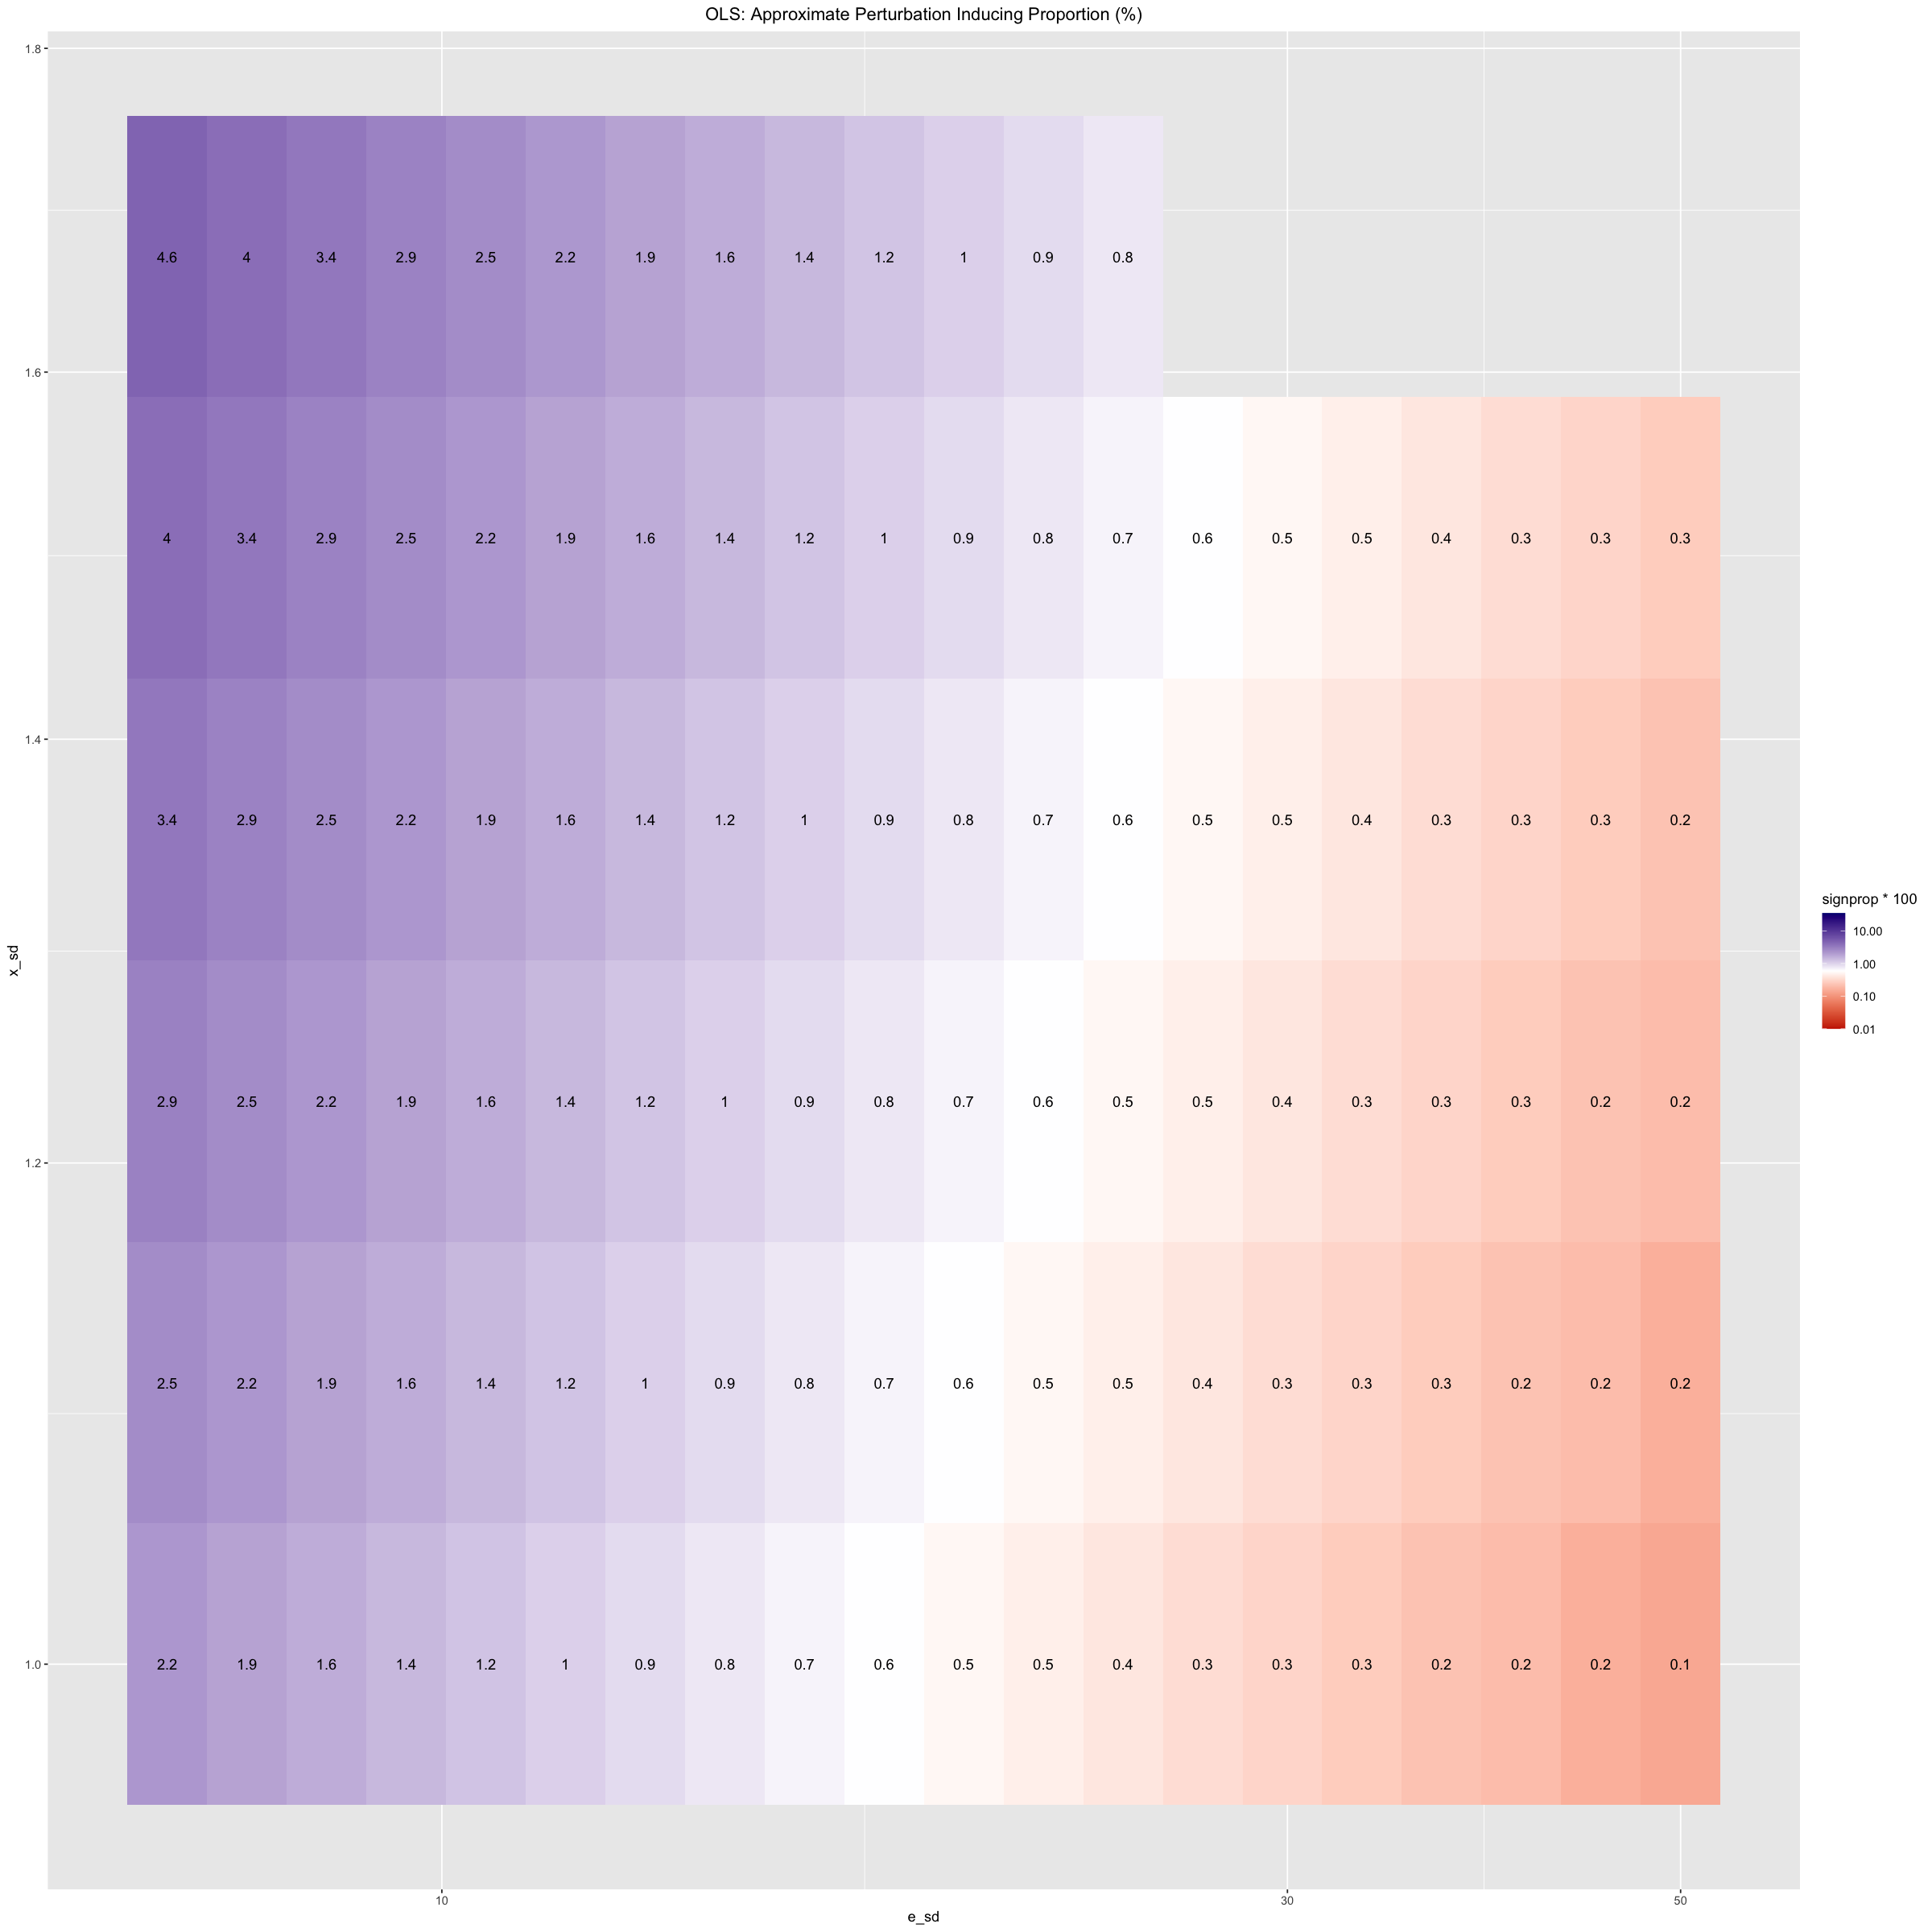

In [57]:
options(repr.plot.width=20, repr.plot.height=20)
ggplot(transf_hm_df, aes(x = e_sd, y = x_sd, fill = signprop*100)) +
  geom_tile() +
  theme(plot.title = element_text(hjust = 0.5)) +
  ggtitle("OLS: Approximate Perturbation Inducing Proportion (%)") +
  scale_fill_gradientn(colors = c("#CA2400", "white", "navy"),
                       values = c(0, .5, 1),
                       limits = c(.01, 35),
                       trans = 'log10') +
  geom_text(aes(label = round(signprop, 3)*100), na.rm = TRUE) +
  scale_x_continuous(trans="log10") +
  scale_y_continuous(trans="log10")

Observations:
* Not as clean as Ryan's Figure 1 plot (not sure why)
* The larger the noise (bottom right) the less data needs to be removed to flip the sign
* When the nois is small ($e_sd$ is relatively small to $x_sd$) there is no small amount of data that will flip the sign

# Building Representative Plots to Analyze Noise

1. Build an individual plot: XY, XR, Abs(X)Abs(R)
1. Build plots for each region of Figure 1 (left)
1. Build plot for noise vs alpha

### Build an individual plot: XY, XR, Abs(X)Abs(R)

In [58]:
#Returns a basic starter plot
BasicPlotMaker <- function(plot_title, plot_df){
  plot <- ggplot(plot_df) +
      theme(plot.title = element_text(hjust = 0.5)) +
      ggtitle(plot_title)
  
  return(plot)
}

#Returns an XY plot of all the simulated data color-coded by if its a dropped point for a qoi
XYPlotMaker <- function(plot_title, plot_df){
  plot <- BasicPlotMaker(plot_title, plot_df) + 
          geom_point(aes(x=x, y=y, color=dropsign), #QOI to color code by ***
                     show.legend = FALSE) + 
          geom_smooth(aes(x=x, y=y),
                      formula = "y ~ x",
                      method='lm')
  return(plot)
}

#Returns a XR (residual) plot ...
XRPlotMaker <- function(plot_title, plot_df){
  plot <- BasicPlotMaker(plot_title, plot_df) + 
    geom_point(aes(x=x, y=r, color=dropsign), #QOI to color code by
               show.legend = FALSE)
  return(plot)
}

#Returns an absolute value of XR (residual) plot ...
ABSXRPlotMaker <- function(plot_title, plot_df){
  plot <- BasicPlotMaker(plot_title, plot_df) + 
    geom_point(aes(x=abs(x), y=abs(r), color=dropsign), #QOI to color code by
               show.legend = FALSE)
  return(plot)
}

InfluenceRPlotMaker <- function(plot_title, plot_df){
  plot <- BasicPlotMaker(plot_title, plot_df) + 
    geom_point(aes(x=x, y=infl, color=dropsign), #QOI to color code by
               show.legend = FALSE)
  return(plot)
}

### Build plots for each region of Figure 1 (left)

In [59]:
#Returns a plot of simulated data marked with drop set
PointGraphWrapper <- function(x_sd, e_sd, y_axis="Y"){ #other possible y value is "R"
  df <- OLSDataGenerator(x_sd, e_sd)
  linear_model <- ModelMaker(df) #fit a linear model
  df$r <- linear_model$residuals #residuals based on the linear model
  
  #Compute influence functions
  model_grads <- ComputeInfluenceFunction(linear_model)
    
  #Compute signals for changes to sign, significance, and both
  signals <- GetInferenceSignals(model_grads)
  
  #Confirm there is a Most Influential Set that flips the sign
  if(signals$"df$x"$sign$apip$success == FALSE){
      return(NULL)
  }
  df <- DataDropper(df, signals$"df$x") # creates a new drop column indicating what needs to be dropped (e.g., dropsign)
  df$infl <- signals$"df$x"$sign$qoi$infl
    
  subplot_title = sprintf("x_sd: %.1f | e_sd: %.1f", x_sd, e_sd)
  if (y_axis == "Y"){
    plot <- XYPlotMaker(subplot_title, df) 
  } else if (y_axis == "R") { #
    plot <- XRPlotMaker(subplot_title, df) 
  } else if (y_axis == "R (ABS)"){
    plot <- ABSXRPlotMaker(subplot_title, df) 
  } else if (y_axis == "Infl"){
    plot <- InfluenceRPlotMaker(subplot_title, df) 
  } else {
    break
  }
  return(plot)
}

In [60]:
#Makes (3 by 3) grid (X by Y/R) plots for different x_sd and e_sd
MegaPlotter <- function(y_axis){
  tl <- PointGraphWrapper(7,       7,          y_axis) # x_sd, e_sd
  tm <- PointGraphWrapper(7,       sqrt(50*7), y_axis)
  tr <- PointGraphWrapper(7,       50,         y_axis)
  cl <- PointGraphWrapper(sqrt(7), 7,          y_axis)
  cm <- PointGraphWrapper(sqrt(7), sqrt(50*7), y_axis)
  cr <- PointGraphWrapper(sqrt(7), 50,         y_axis)
  bl <- PointGraphWrapper(1,       7,          y_axis)
  bm <- PointGraphWrapper(1,       sqrt(50*7), y_axis)
  br <- PointGraphWrapper(1,       50,         y_axis)
  
  mega_plot <- grid.arrange(tl, tm, tr,
                             cl, cm, cr,
                             bl, bm, br,
                             nrow = 3, ncol = 3,
                             top = sprintf("OLS: X by %s (QOI: Sign) and (theta = +.5)", y_axis))
  return(mega_plot)
 }

In [67]:
#Plot for each region of Figure 1 (left)
plotxy <- MegaPlotter("Y")

In [ ]:
plotxr <- MegaPlotter("R")

In [ ]:
plotxr <- MegaPlotter("R (ABS)")

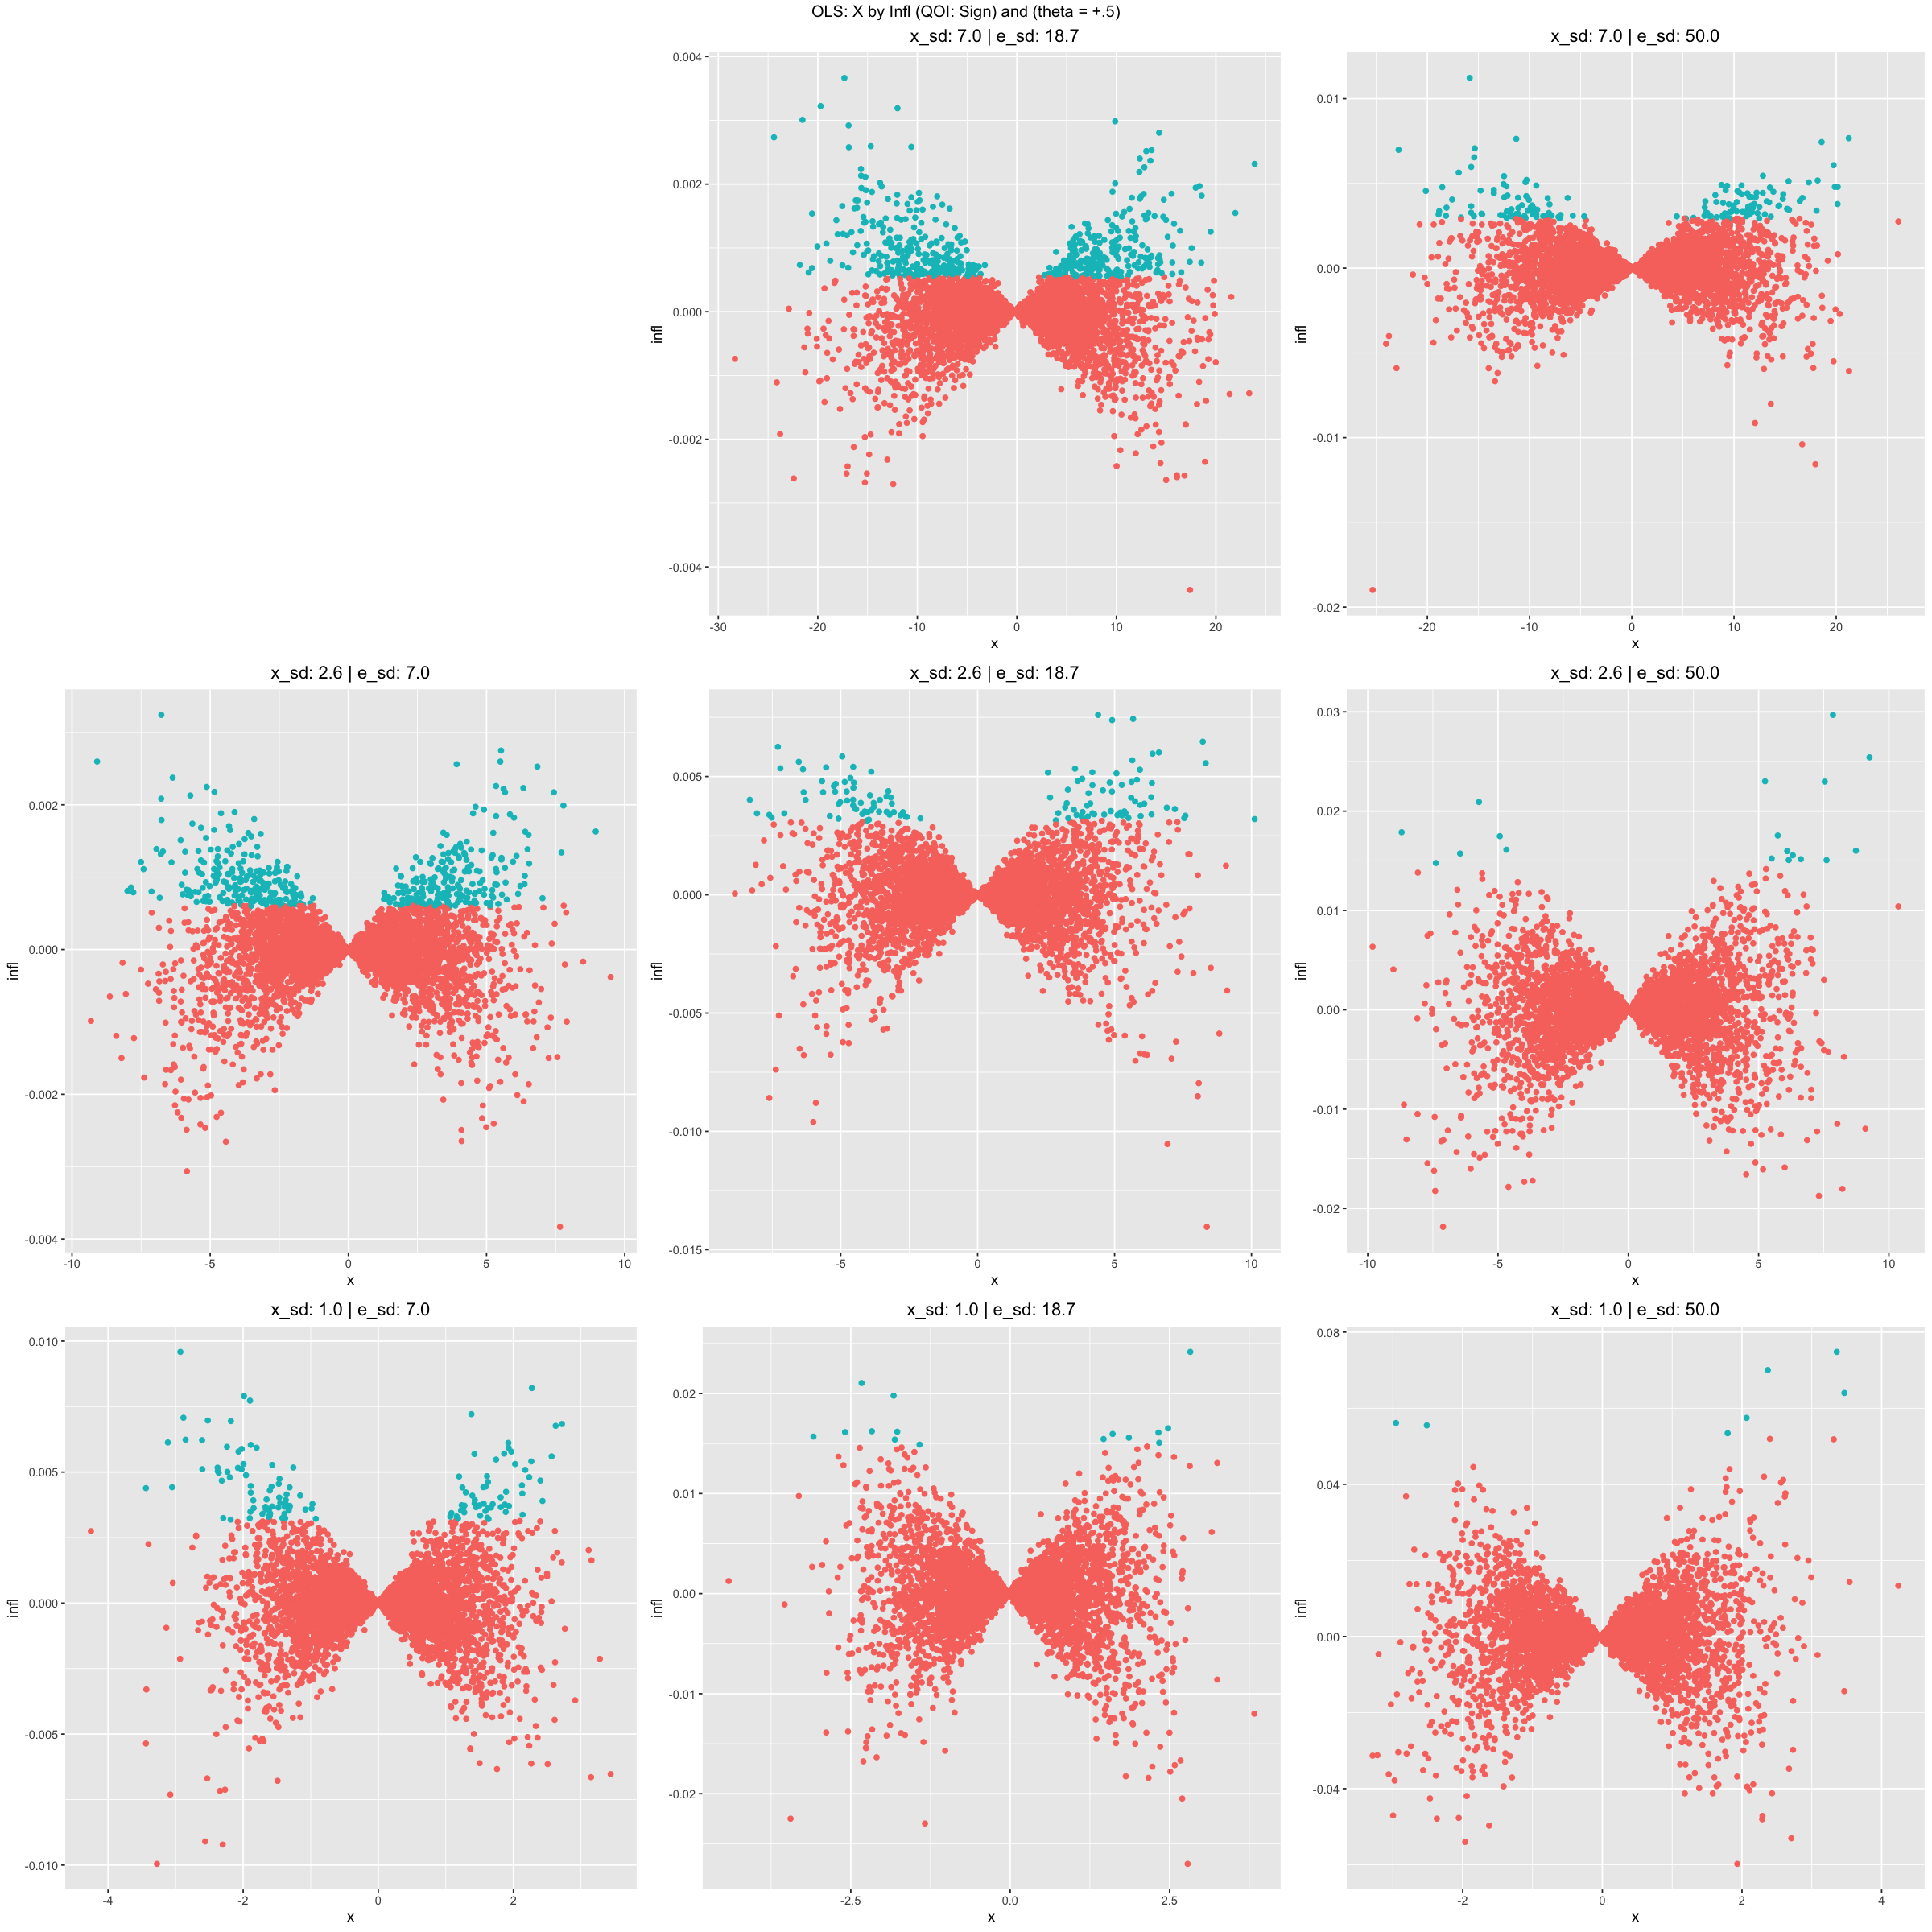

In [64]:
plotxy <- MegaPlotter("Infl")

Observations from regional plots: 
* when the noise is large (bottom right corner) there are fewer points that need to be dropped (alpha is smaller)
    * See following plot
* for positive $\theta$ removing points in upper right (high x and high y) and lower left (low x and low y) changes the sign of the estimator (makes it negative). 
* the removed points correspond to large absolute values of x and r. 

### 3. Graph Noise vs. $\alpha$ (Maximum Influence Proportion)

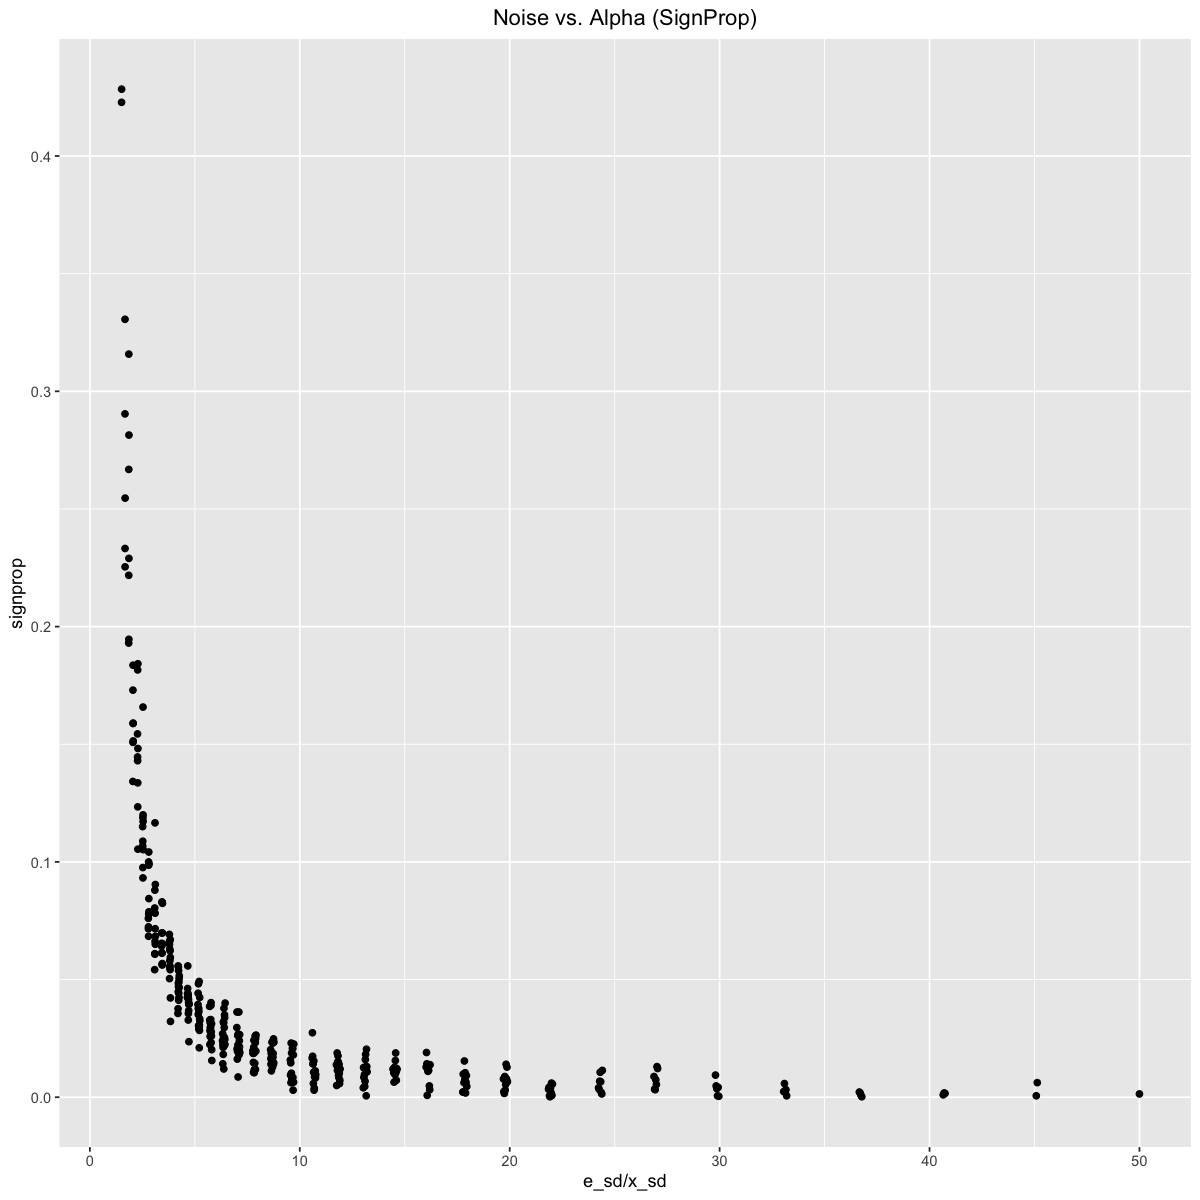

In [356]:
#Returns an XY plot of all the simulated data color-coded by if its a dropped point for a qoi
NoiseAlphaPlotMaker <- function(plot_title, plot_df){
  plot <- BasicPlotMaker(plot_title, plot_df) + 
          geom_point(aes(x=e_sd/x_sd, y=signprop), #QOI to color code by ***
                     na.rm = TRUE,
                     show.legend = FALSE)
  return(plot)
}

NoiseAlphaPlotMaker("Noise vs. Alpha (SignProp)", hm_df) 

Observations from SignProp graphs:
* There is an inverse relationship between the noise, $\frac{\sigma_x}{\sigma_e}$ and the Maximum Influence Proportion, $\alpha$ such that as the more noise the less data needs to be removed to change the sign. 

# Look at P vs Alpha value as N grows

In [377]:
#Return model's p value from lm (linear model) object
get_p <- function(my_model) {
    f <- summary(my_model)$fstatistic
    p <- pf(f[1],f[2],f[3],lower.tail=F)
    attributes(p) <- NULL
    return(p)
}


#Holding x_sd and e_sd constant vary observation count and track alpha and p values
ModelFitter <- function(r_df, n){
    df <- OLSDataGenerator(1, sqrt(50*7), n=n)
    linear_model <- ModelMaker(df) #fit a linear model
    
    #Compute influence functions
    model_grads <- ComputeInfluenceFunction(linear_model)

    #Compute signals for changes to sign, significance, and both
    signals <- GetInferenceSignals(model_grads)

    roi <- signals$"df$x" #regressor of interest
    
    r_df <- r_df %>% add_row(a=roi$sign$apip$prop, 
                             p=get_p(linear_model), 
                             n=n,
                             se=get_se(linear_model))
    return(r_df)
}

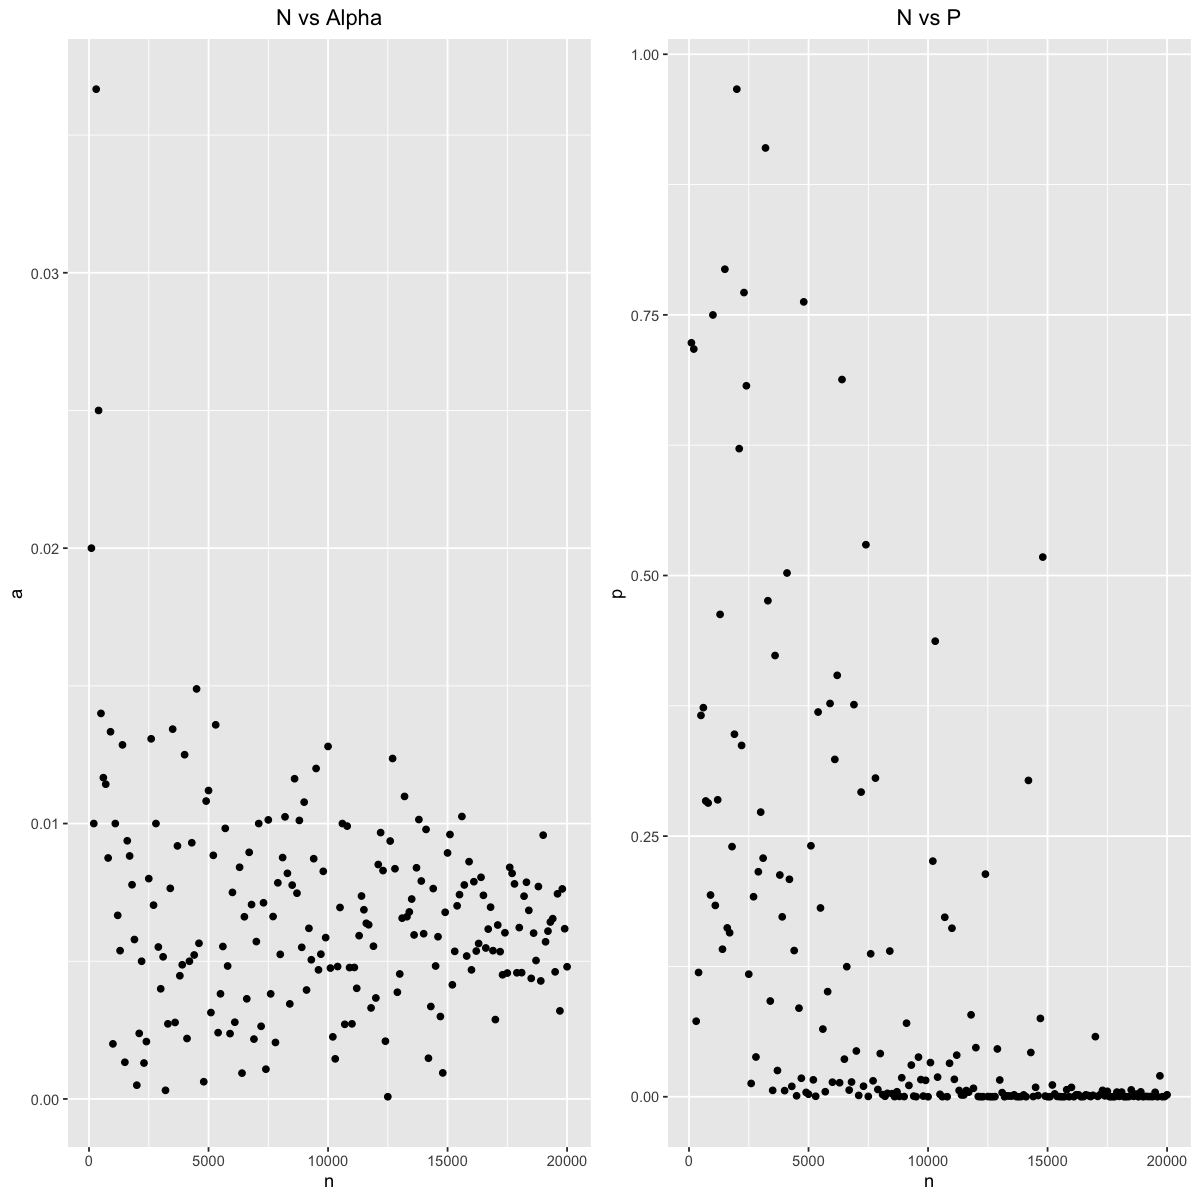

In [387]:
robustness_df <- data.frame(a = numeric(), #alpha
                            p = numeric(), #p value
                            n = numeric(),
                            se = numeric()) #number of observations

#Iterate through different values for N
for (i in seq(100, 20000, 100)){
    robustness_df <- ModelFitter(robustness_df, i)
}

#Plot N vs Alpha
plot_na <- BasicPlotMaker("N vs Alpha", robustness_df) + 
        geom_point(aes(x=n, 
                       y=a),
                   na.rm = TRUE,
                   show.legend = FALSE)

#Plot Alpha vs N
plot_np <- BasicPlotMaker("N vs P", robustness_df) + 
        geom_point(aes(x=n, 
                       y=p),
                   na.rm = TRUE,
                   show.legend = FALSE)


#Display plots next to eachother
grid.arrange(plot_na, plot_np,
             nrow = 1)